In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)
import yfinance as yf
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis

from utils.kalman_functions import likelihood, kalman_filter, kalman_smoother, bootstrap_filter

FIGURE_PATH = "./figures/"

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### a)

In [2]:
df = pd.read_excel("data/sv.xlsx")
df.head()

,GBPUSD
0,-0.355532
1,1.425409
2,-0.443940
3,1.025650
4,1.677579


In [3]:
df['returns'] = df['GBPUSD']/100
print(df['returns'].describe())
print('skewness:', skew(df['returns']))
print('kurtosis:', kurtosis(df['returns']))

count    945.000000
mean      -0.000353
std        0.007111
min       -0.032961
25%       -0.004394
50%       -0.000457
75%        0.003644
max        0.045345
Name: returns, dtype: float64
skewness: 0.6041771319562368
kurtosis: 4.8619099904534755


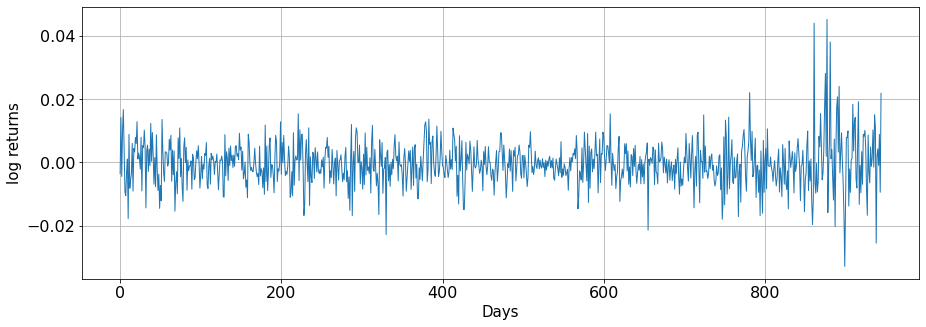

In [4]:
plt.figure(figsize=(15,5))
plt.plot(df['returns'], linewidth= 1)
plt.grid()
plt.xlabel('Days', fontsize = 15)
plt.ylabel('log returns', fontsize = 15)
plt.savefig(FIGURE_PATH + 'fig2.1.png')
plt.show()

### b)

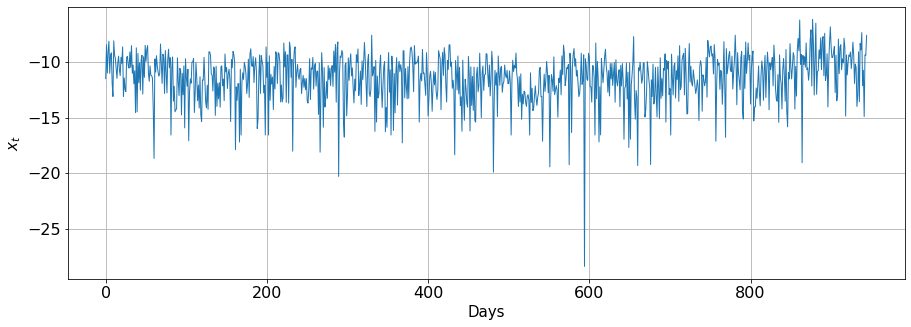

,GBPUSD,returns,xt
0,-0.355532,-0.003555,-11.487826
1,1.425409,0.014254,-8.452482
2,-0.443940,-0.004439,-11.000233
3,1.025650,0.010257,-9.091992
4,1.677579,0.016776,-8.133977


In [5]:
df['xt'] = np.log((df['returns'] - df['returns'].mean())**2)
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(df['xt'], linewidth = 1)
plt.xlabel('Days', fontsize = 15)
plt.ylabel(r'$x_t$ ', fontsize = 15)
plt.savefig(FIGURE_PATH + 'fig2.2.png')
plt.show()
df.head()

### c)

In [6]:

# initial values
phi = 0.995
omega = (1 - phi) * (df['xt'].mean() + 1.27)
s2_eta = (1 - phi) * (np.var(df['xt']) - np.pi**2/2)

# initial state variable and its variance
a0 = omega / (1 - phi)
P0 = s2_eta / (1 - phi**2)

# observation matrix
H = np.pi**2/2

# minimize negative log likelihood
params0 = [omega, phi, s2_eta]
bounds = ((None, None), (0, 1), (0, None))
res = minimize(fun=likelihood, x0=params0, args=(a0, P0, df['xt'], H), bounds=bounds, options={'maxiter':5000})

# show results
omega_hat, phi_hat, s2_eta_hat = res.x
if res.success:
    print(res.x)
else:
    print("No success, message: %s" % res.message)
    print(res.x)

[-0.10045639  0.99006818  0.00741708]


### d)

In [7]:
# compute the kalman filtered state with the above estimated parameters
df_kf = kalman_filter(res.x, df['xt'])
df_kf

,a_filter,P,v,F,K,h_filter
0,-10.114597,0.375263,-0.103229,5.310066,0.069968,0.000000
1,-10.121819,0.349268,2.939337,5.284070,0.065442,-0.007223
2,-9.929392,0.327152,0.199160,5.261954,0.061556,0.185204
3,-9.918972,0.308165,2.096981,5.242967,0.058193,0.195624
4,-9.798886,0.291736,2.934908,5.226538,0.055264,0.315711
...,...,...,...,...,...,...
940,-9.244268,0.151491,-0.231481,5.086293,0.029488,0.870329
941,-9.259738,0.151491,-4.372394,5.086293,0.029488,0.854859
942,-9.397163,0.151491,1.304689,5.086293,0.029488,0.717434
943,-9.365815,0.151491,1.238288,5.086293,0.029488,0.748782


In [8]:
# compute the kalman smoothed state for the above estimated parameters
df_ks = kalman_smoother(res.x, df['xt'])
df_ks

,r,a_smoother,N,V,h_smoother
0,1.823059,-9.430470,1.621077,0.146979,0.684127
1,2.002499,-9.422412,1.692397,0.142816,0.692185
2,1.564129,-9.417685,1.758204,0.138974,0.696912
3,1.643790,-9.412414,1.818926,0.135430,0.702182
4,1.334760,-9.409488,1.874954,0.132159,0.705108
...,...,...,...,...,...
940,0.082500,-9.231770,0.842381,0.132159,0.882827
941,0.133264,-9.239549,0.699864,0.135430,0.875047
942,1.033654,-9.240573,0.545410,0.138974,0.874023
943,0.809035,-9.243253,0.378019,0.142816,0.871343


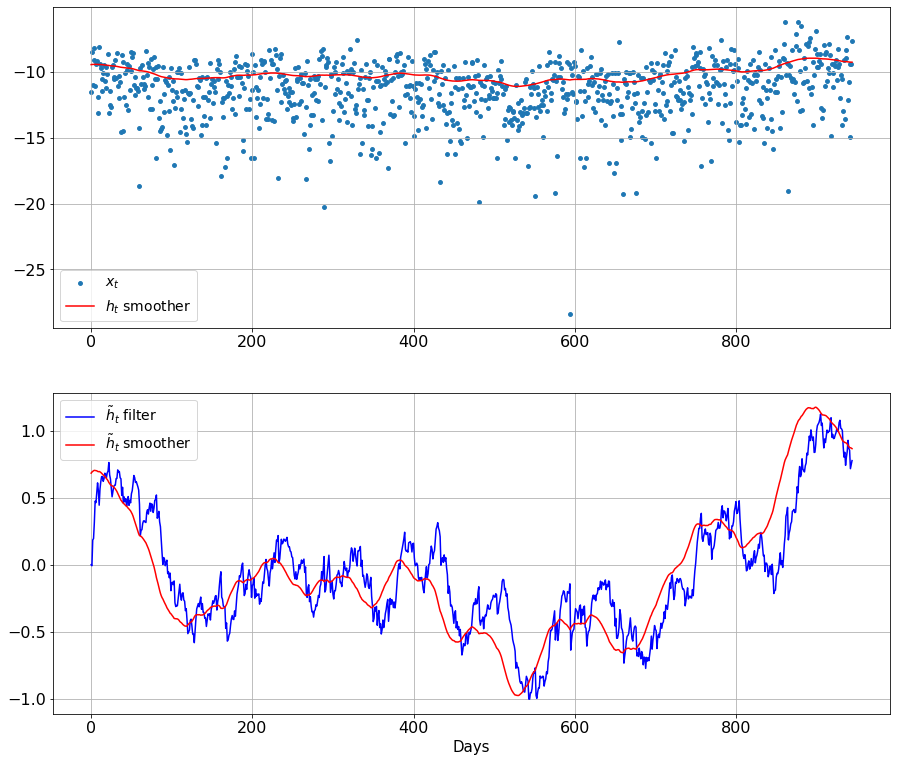

In [9]:
# plot smoothed and filtered state
fig, axs = plt.subplots(2,1, figsize=(15,13))

# upper plot
ax = axs[0]
ax.scatter(df.index, df.xt, s=15, label = r'$x_t$')
ax.plot(df.index, df_ks.a_smoother, color = 'r', label = r"$h_t$ smoother")
ax.legend(fontsize = 14)

# lower plot
ax = axs[1]
ax.plot(df.index, df_kf.h_filter, color = 'b', label = r"$\tilde{h}_t$ filter")
ax.plot(df.index, df_ks.h_smoother, color = 'r', label = r"$\tilde{h}_t$ smoother" )
ax.set_xlabel('Days', fontsize = 15)
ax.legend(fontsize = 14)

for ax in axs:
    ax.grid()
    pass

plt.savefig(FIGURE_PATH + 'fig2.3.png')
plt.show()

### e) (part 1)

In [16]:
tickers = ['^GSPC']
start_date = '2016-02-09'
end_date = '2021-02-11'

data = yf.download(tickers, start=start_date, end=end_date)
# extract the adjusted close prices for the tickers
daily_returns = data['Adj Close'].pct_change()
df_tick = pd.DataFrame({"sp": daily_returns}).reset_index()[1:]


# df_tick = pd.DataFrame(daily_returns).reset_index()[1:]
# df_tick = df_tick.rename(columns={'^GSPC': 'sp'})
df_tick['xt'] = np.log((df_tick.sp - df_tick.sp.mean())**2)
df_tick = df_tick.reset_index(drop=True)
df_tick

[*********************100%***********************]  1 of 1 completed


,Date,sp,xt
0,2016-02-10,-0.000189,-14.129266
1,2016-02-11,-0.012301,-8.690692
2,2016-02-12,0.019518,-7.942252
3,2016-02-16,0.016517,-8.289071
4,2016-02-17,0.016480,-8.293646
...,...,...,...
1255,2021-02-04,0.010853,-9.173195
1256,2021-02-05,0.003897,-11.469533
1257,2021-02-08,0.007399,-10.001323
1258,2021-02-09,-0.001114,-12.662977


In [ ]:
tickers = ['^GSPC', 'AAPL']
start_date = '2016-02-09'
end_date = '2021-02-11'

data = yf.download(tickers, start=start_date, end=end_date)
# extract the adjusted close prices for the tickers
adj_close = data['Adj Close']

# calculate the daily returns for the tickers
daily_returns = adj_close.pct_change()

df_tick = pd.DataFrame(daily_returns).reset_index()[1:]
df_tick = df_tick.rename(columns={'^GSPC': 'sp'})
df_tick['xt'] = np.log((df_tick.sp - df_tick.sp.mean())**2)
df_tick = df_tick.reset_index(drop=True)
df_tick

[*********************100%***********************]  2 of 2 completed


,Date,AAPL,sp,xt
0,2016-02-10,-0.007580,-0.000189,-14.129266
1,2016-02-11,-0.006046,-0.012301,-8.690692
2,2016-02-12,0.003095,0.019518,-7.942252
3,2016-02-16,0.028194,0.016517,-8.289071
4,2016-02-17,0.015315,0.016480,-8.293646
...,...,...,...,...
1255,2021-02-04,0.025758,0.010853,-9.173195
1256,2021-02-05,-0.003098,0.003897,-11.469533
1257,2021-02-08,0.001097,0.007399,-10.001323
1258,2021-02-09,-0.006574,-0.001114,-12.662977


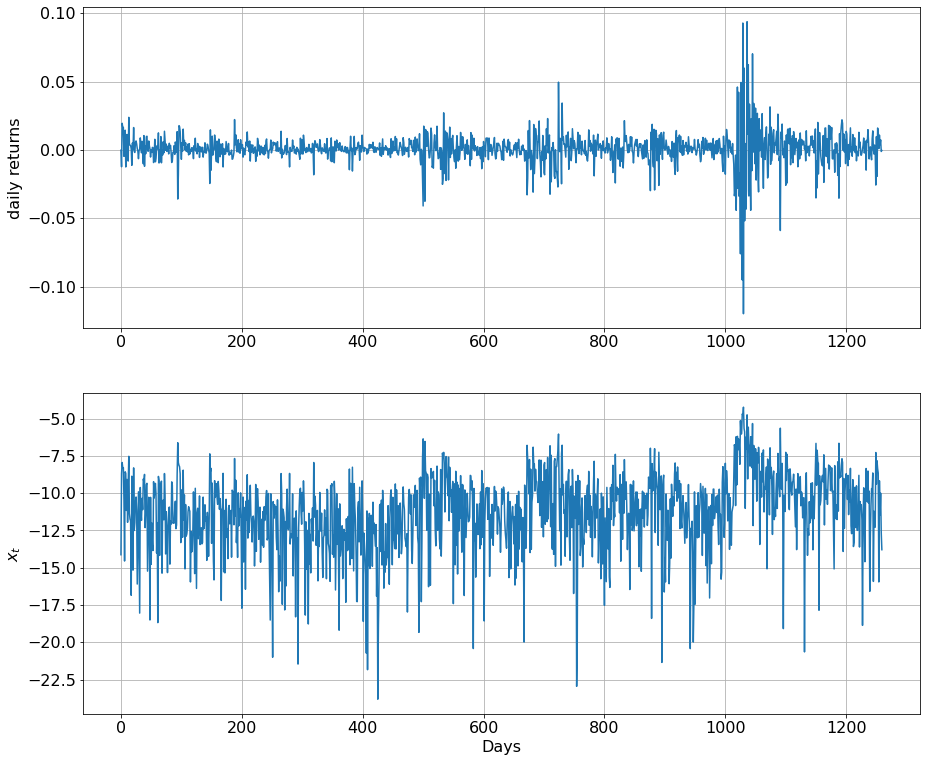

In [17]:
fig, axs = plt.subplots(2,1, figsize=(15,13))

# upper left
ax = axs[0]

ax.plot(df_tick.index, df_tick.sp)
ax.set_ylabel('daily returns', fontsize=16)

ax = axs[1]
ax.plot(df_tick.index, df_tick.xt)
ax.set_ylabel(r'$x_t$', fontsize=16)
ax.set_xlabel('Days', fontsize=16)

for ax in axs:
    ax.grid()
    pass

plt.savefig(FIGURE_PATH + 'fig2.e1.png')
plt.show()

In [18]:
# Define the linearized model parameters
phi = 0.995
omega = (1 - phi) * (df_tick['xt'].mean() + 1.27)
s2_eta = (1 - phi) * (np.var(df_tick['xt']) - np.pi**2/2)

# Define the initial state variables and their covariance
a0 = omega / (1 - phi)
P0 = s2_eta / (1 - phi**2)

# Define the observation matrix and covariance
H = np.pi**2/2

params0 = [omega, phi, s2_eta]
bounds = ((None, None), (0, 1), (0, None))
res_e = minimize(fun=likelihood, x0=params0, args=(a0, P0, df_tick['xt'], H), bounds=bounds, options={'maxiter':5000})
  
omega_hat, phi_hat, s2_eta_hat = res_e.x

print(res_e.x)


[-0.30014286  0.97019816  0.1052841 ]


In [19]:
df_kf_1 = kalman_filter(res_e.x, df_tick['xt'])
df_ks = kalman_smoother(res_e.x, df_tick['xt'])

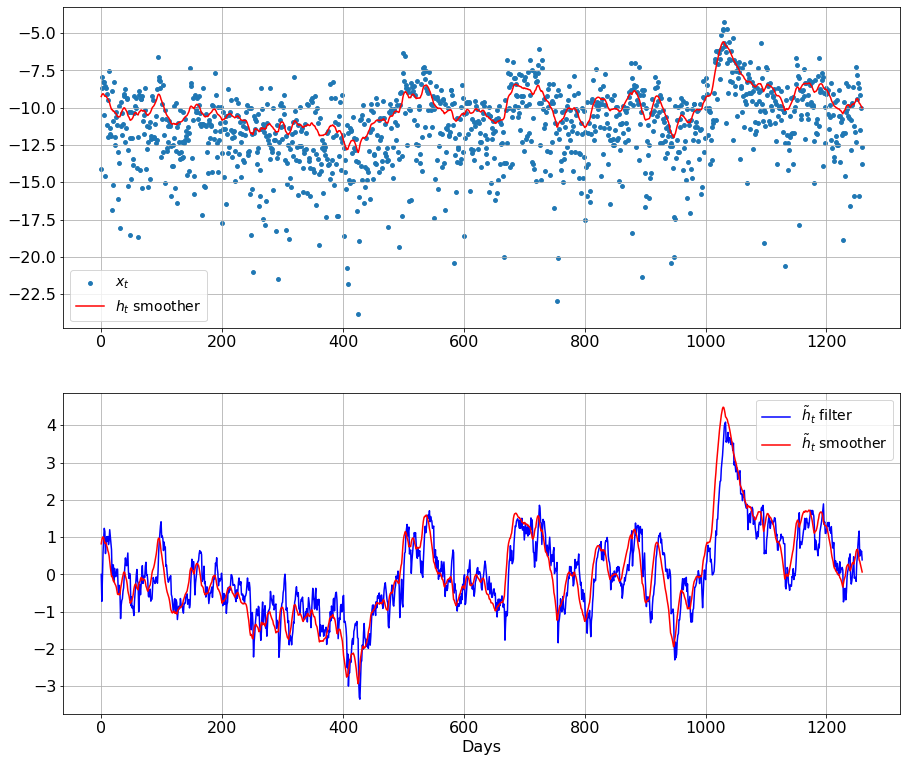

In [20]:
fig, axs = plt.subplots(2,1, figsize=(15,13))

# upper left
ax = axs[0]

ax.scatter(df_tick.index, df_tick.xt, s=15, label = r'$x_t$')
# ax.plot(df_tick.index, df_kf_1.a_filter, color = 'b', label = r'$h_t$ filter')
ax.plot(df_tick.index, df_ks.a_smoother, color = 'r', label = r"$h_t$ smoother")
ax.legend(fontsize = 14)

ax = axs[1]
ax.plot(df_tick.index, df_kf_1.h_filter, color = 'b', label = r"$\tilde{h}_t$ filter")
ax.plot(df_tick.index, df_ks.h_smoother, color = 'r', label = r"$\tilde{h}_t$ smoother" )
ax.set_xlabel('Days', fontsize=16)
ax.legend(fontsize = 14)

for ax in axs:
    ax.grid()
    pass

plt.savefig(FIGURE_PATH + 'fig2.e2.png', dpi=300)
plt.show()

### e) part 2

In [21]:
# read dataframe and select only data from SP500 after 2016-2-10
df_rv = pd.read_csv('data/realized_volatility.csv')
df_rv = df_rv[(df_rv['Symbol'] == '.SPX')].reset_index(drop=True)
df_rv['date'] = pd.to_datetime(df_rv['date'])
df_rv = df_rv[df_rv.date >= pd.to_datetime('2016-02-10 00:00:00+00:00')].reset_index(drop=True)
df_rv = df_rv[['date', 'Symbol', 'rv5']]

# add the log returns from previous data to df 
df_rv['xt'] = df_tick['xt']

# transform RV
df_rv['rv_adj'] = np.log(df_rv['rv5']) - 1.27

# we chose the augmentation method
df_kf_xt = kalman_filter(res_e.x, df_rv['xt'])
df_kf_rv = kalman_filter(res_e.x, df_rv['rv_adj'])

# compute beta
beta = (sum(df_kf_rv.v * df_kf_xt.F**-1  * df_kf_rv.v))**-1 * sum(df_kf_rv.v * (df_kf_xt.F**-1) * df_kf_xt.v)
df_rv['xt_adj'] = df_rv['xt'] - beta * np.log(df_rv['rv5'])
df_rv

,date,Symbol,rv5,xt,rv_adj,xt_adj
0,2016-02-10 00:00:00+00:00,.SPX,0.000165,-14.129266,-9.979408,-7.891384
1,2016-02-11 00:00:00+00:00,.SPX,0.000305,-8.690692,-9.365040,-2.892835
2,2016-02-12 00:00:00+00:00,.SPX,0.000097,-7.942252,-10.511011,-1.323624
3,2016-02-16 00:00:00+00:00,.SPX,0.000093,-8.289071,-10.557964,-1.636813
4,2016-02-17 00:00:00+00:00,.SPX,0.000073,-8.293646,-10.788903,-1.475984
...,...,...,...,...,...,...
1245,2021-02-04 00:00:00+00:00,.SPX,0.000020,-15.920105,-12.077224,-8.179718
1246,2021-02-05 00:00:00+00:00,.SPX,0.000023,-11.211605,-11.970449,-3.547692
1247,2021-02-08 00:00:00+00:00,.SPX,0.000022,-11.651913,-11.980094,-3.981093
1248,2021-02-09 00:00:00+00:00,.SPX,0.000009,-12.280215,-12.846193,-3.989074


In [22]:
# Define the linearized model parameters
phi = 0.995
omega = (1 - phi) * (df_rv['xt_adj'].mean() + 1.27)
s2_eta = (1 - phi) * (np.var(df_rv['xt_adj']) - np.pi**2/2)

# Define the initial state variables and their covariance
a0 = omega / (1 - phi)
P0 = s2_eta / (1 - phi**2)

# Define the observation matrix and covariance
H = np.pi**2/2

params0 = [omega, phi, s2_eta]
bounds = ((None, None), (0, 1), (0, None))
res_e2 = minimize(fun=likelihood, x0=params0, args=(a0, P0, df_rv['xt_adj'], H), bounds=bounds, options={'maxiter':5000})
  
omega_hat, phi_hat, s2_eta_hat = res_e2.x
if res_e2.success:
    print(res_e2.x, beta)
else:
    print("No success, message: %s" % res_e2.message)
    print(res_e2.x)


[-0.04634426  0.98184224  0.01087638] 0.7162234371285104


In [23]:
# for the estimated parameters above and xt_adj (= xt - beta * log RV)
# compute the kalman filtered and smoothed state
df_kf3 = kalman_filter(res_e2.x, df_rv['xt_adj'])
df_ks3 = kalman_smoother(res_e2.x, df_rv['xt_adj'])

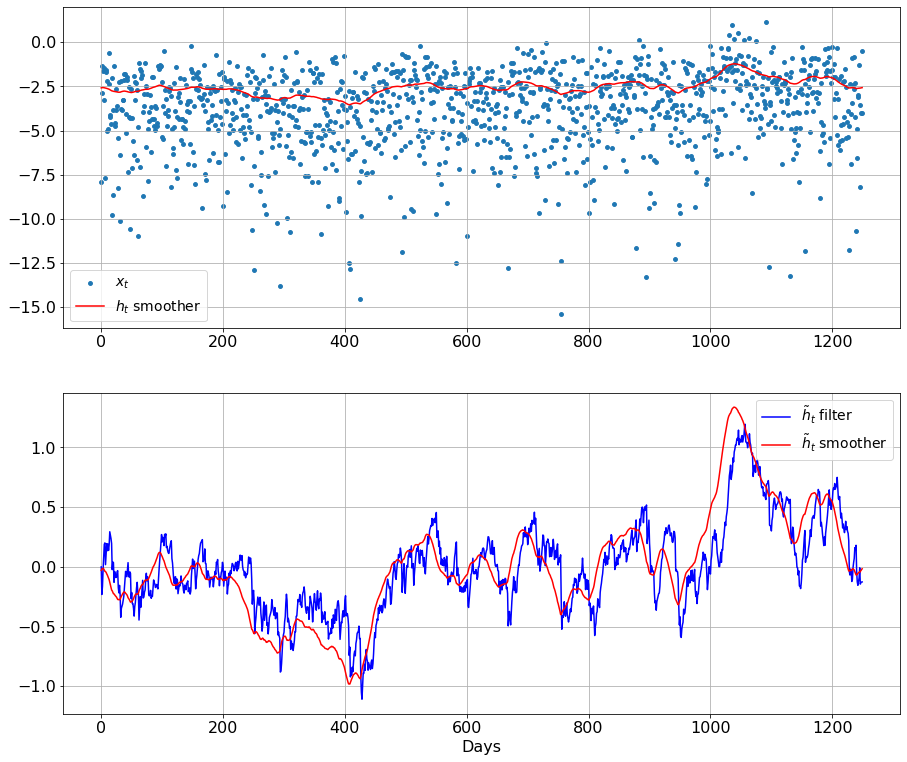

In [24]:
fig, axs = plt.subplots(2,1, figsize=(15,13))

# upper plot
ax = axs[0]
ax.scatter(df_rv.index, df_rv.xt_adj, s=15, label = r'$x_t$')
ax.plot(df_kf3.index, df_ks3.a_smoother, color = 'r', label = r"$h_t$ smoother")
ax.legend(fontsize = 14)

# lower plot
ax = axs[1]
ax.plot(df_kf3.index, df_kf3.h_filter, color = 'b', label = r"$\tilde{h}_t$ filter")
ax.plot(df_kf3.index, df_ks3.h_smoother, color = 'r', label = r"$\tilde{h}_t$ smoother" )
ax.set_xlabel('Days', fontsize=16)
ax.legend(fontsize = 14)

for ax in axs:
    ax.grid()
    pass

plt.savefig(FIGURE_PATH + 'fig2.e3.png', dpi=300)
plt.show()

### f)

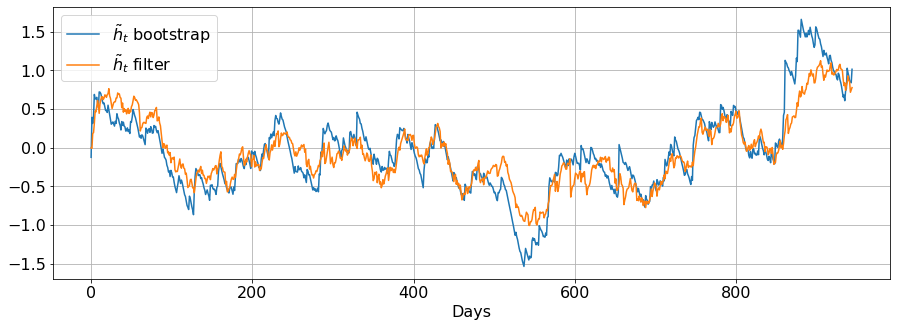

In [30]:
# compute bootstrap filter for original sv.xlsx data
df_bs = bootstrap_filter(params=res.x, N=10000, y=df['returns'])
plt.figure(figsize=(15,5))
plt.plot(df_bs.a_bootstrap, label=r'$\tilde{h}_t$ bootstrap')
plt.plot(df_kf.h_filter, label=r'$\tilde{h}_t$ filter')
plt.grid()
plt.legend(fontsize=16)
plt.xlabel('Days', fontsize=16)
plt.savefig(FIGURE_PATH + 'fig2.f1.png', dpi=300)
plt.show()

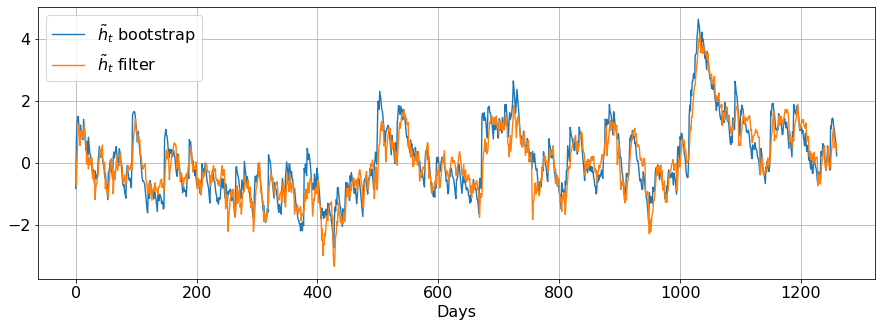

In [32]:
# compute bootstrap filter for sp500 return data
df_bs = bootstrap_filter(params=res_e.x, N=10000, y=df_tick['sp'])
plt.figure(figsize=(15,5))
plt.plot(df_bs.a_bootstrap, linewidth=1.4, label=r'$\tilde{h}_t$ bootstrap')
plt.plot(df_kf_1.h_filter, linewidth=1.4, label=r'$\tilde{h}_t$ filter')
plt.grid()
plt.legend(fontsize=16)
plt.xlabel('Days', fontsize=16)
plt.savefig(FIGURE_PATH + 'fig2.f2.png', dpi=300)
plt.show()